# Project Overview
Penyakit kardiovaskular (CVD) merupakan penyebab kematian utama secara global, menelan sekitar 17,9 juta nyawa setiap tahunnya, yang menyumbang sebanyak 31% dari total kematian di seluruh dunia. Empat dari 5 kematian akibat CVD disebabkan oleh serangan jantung dan stroke, dan sepertiga dari kematian ini terjadi secara prematur pada orang yang berusia di bawah 70 tahun. Gagal jantung adalah kejadian umum yang disebabkan oleh CVD, dan dataset ini berisi 13 fitur yang dapat digunakan untuk memprediksi kemungkinan penyakit jantung.

Orang-orang yang menderita penyakit kardiovaskular atau berisiko tinggi terkena penyakit jantung (karena adanya satu atau lebih faktor risiko seperti hipertensi, diabetes, hiperlipidemia, atau sudah menderita penyakit tersebut) memerlukan deteksi dan penanganan dini di mana model pembelajaran mesin dapat memberikan bantuan yang besar.

Model dibuat untuk memprediksi keselamatan pasien dari penyakit jantung berdasarkan data yang tersedia.

Data ini memiliki 13 atribut.
1. age - umur pasien
2. anaemia - apakah ada pengurangan haemoglobin
3. creatinine_phosphokinase - level enzim CPK dalam mcg/L
4. diabetes - apakah pasien punya riwayat diabetes
5. ejection_fraction - persentase darah yang meninggalkan jantung dalam persentasi di setiap kontraksi jantung
6. high_blood_pressure - apakah pasien punya darah tinggi
7. platelets - jumlah platelet di darah dalam kiloplatelets/mL
8. serum_creatinine - level serum creatinine di darah dalam mg/dL
9. serum_sodium - level serum sodium di darah dalam mEq/L
10. sex - apakah pasien pria atau wanita
11. smoking - apakah pasien merokok
12. time - waktu dalam hari untuk follow-up
13. DEATH_EVENT - apakah pasien sudah meninggal saat waktu follow-up

Kelompok ini terdiri dari = Arya Rahman, Yusraini Asra, Monica Belinda

# Import pustaka

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simps

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump,load

#Importing necessary packages
import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

# Data Loading

In [2]:
# Import dataset
df = pd.read_csv("C:\\Users\\Gaming\\Documents\\Jupiter\\heart_failure_clinical_records_dataset.csv")
df.columns = df.columns.str.lower()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#Check the shape of dataset
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 299
Number of Columns	: 13


In [4]:
# looking variable type, null values, number of unique values and sample
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

,type,null,null_percentage,unique,sample
age,float64,0,0.0,47,51.0
anaemia,int64,0,0.0,2,1.0
creatinine_phosphokinase,int64,0,0.0,208,7702.0
diabetes,int64,0,0.0,2,0.0
ejection_fraction,int64,0,0.0,17,14.0
high_blood_pressure,int64,0,0.0,2,1.0
platelets,float64,0,0.0,176,184000.0
serum_creatinine,float64,0,0.0,40,2.0
serum_sodium,int64,0,0.0,27,142.0
sex,int64,0,0.0,2,1.0


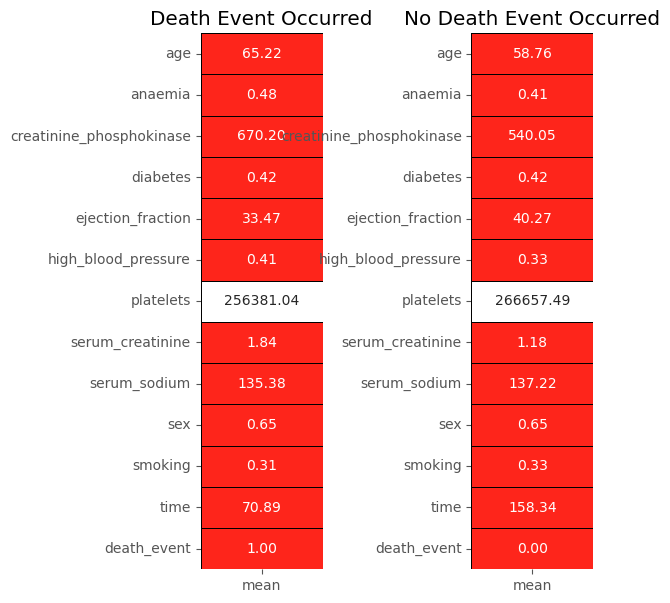

In [5]:
yes = df[df['death_event'] == 1].describe().T
no = df[df['death_event'] == 0].describe().T

colors = ['#FE251B','#FFFFFF']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5),)
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Death Event Occurred');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Death Event Occurred');

fig.tight_layout(pad = -3)

# Explorasi Data

In [6]:
#Membagi data kedalam dua kelompok berdasarkan type data
cat_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking","death_event"]
num_cols = [i for i in df.columns if i not in cat_cols]

print(f"Categorical Columns\t({len(cat_cols)})\t: {list(cat_cols)}")
print(f"Numerical Columns\t({len(num_cols)})\t: {list(num_cols)}")

Categorical Columns	(6)	: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
Numerical Columns	(7)	: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


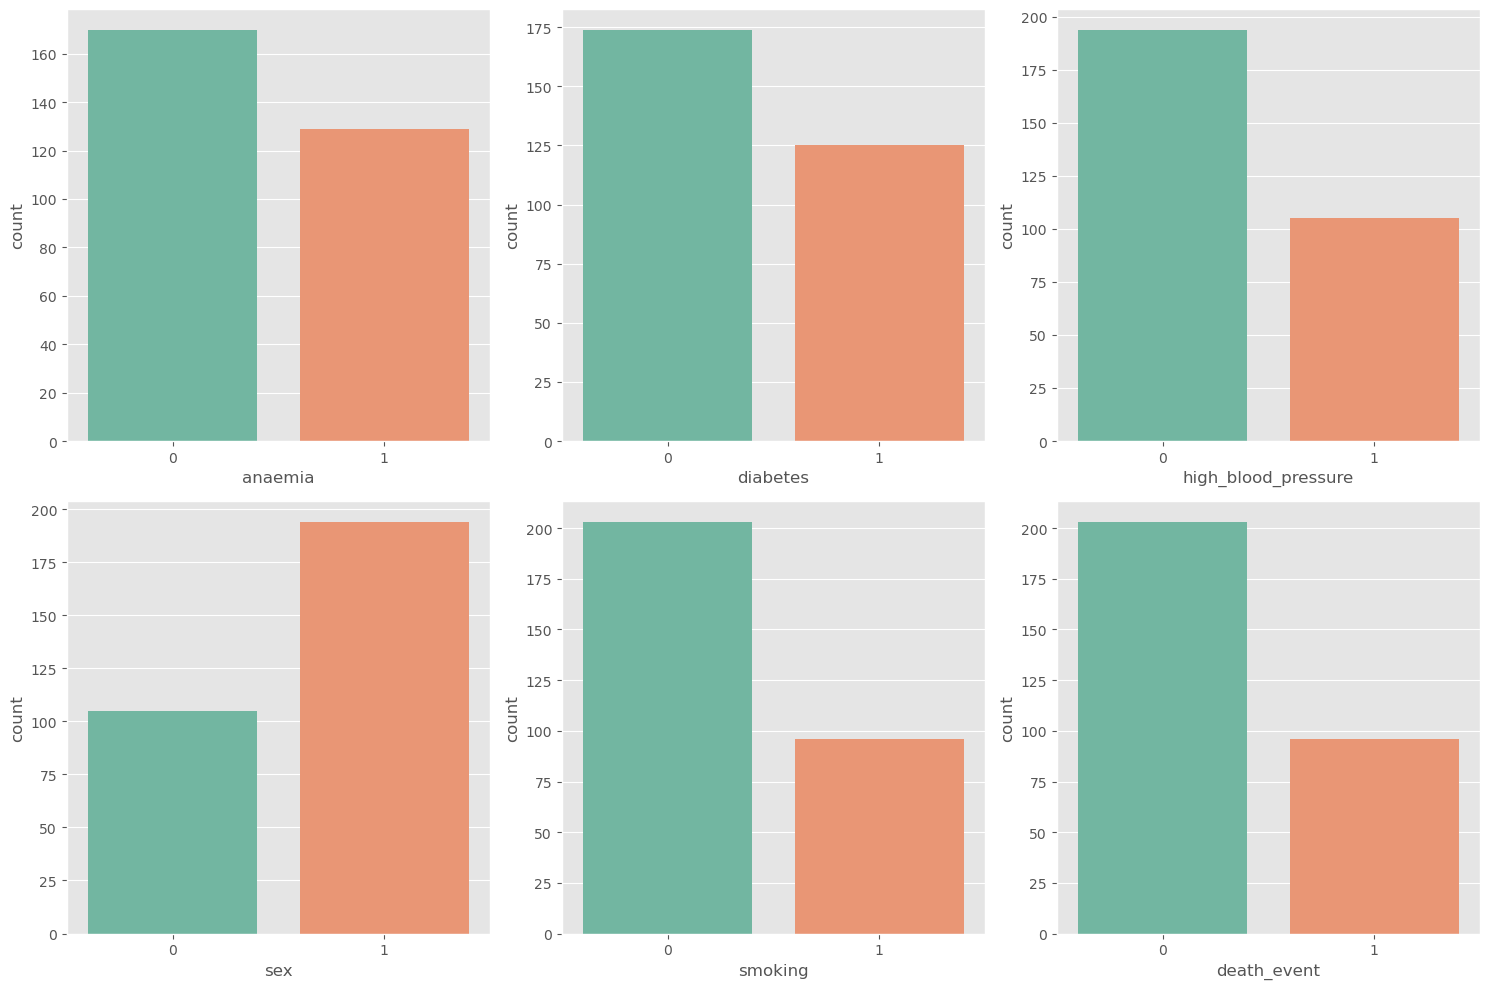

In [7]:
# melihat distribusi dari kolom categorical
colors = sns.color_palette()  

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, palette='Set2', ax=ax[i//3, i%3])

plt.tight_layout()
plt.show()

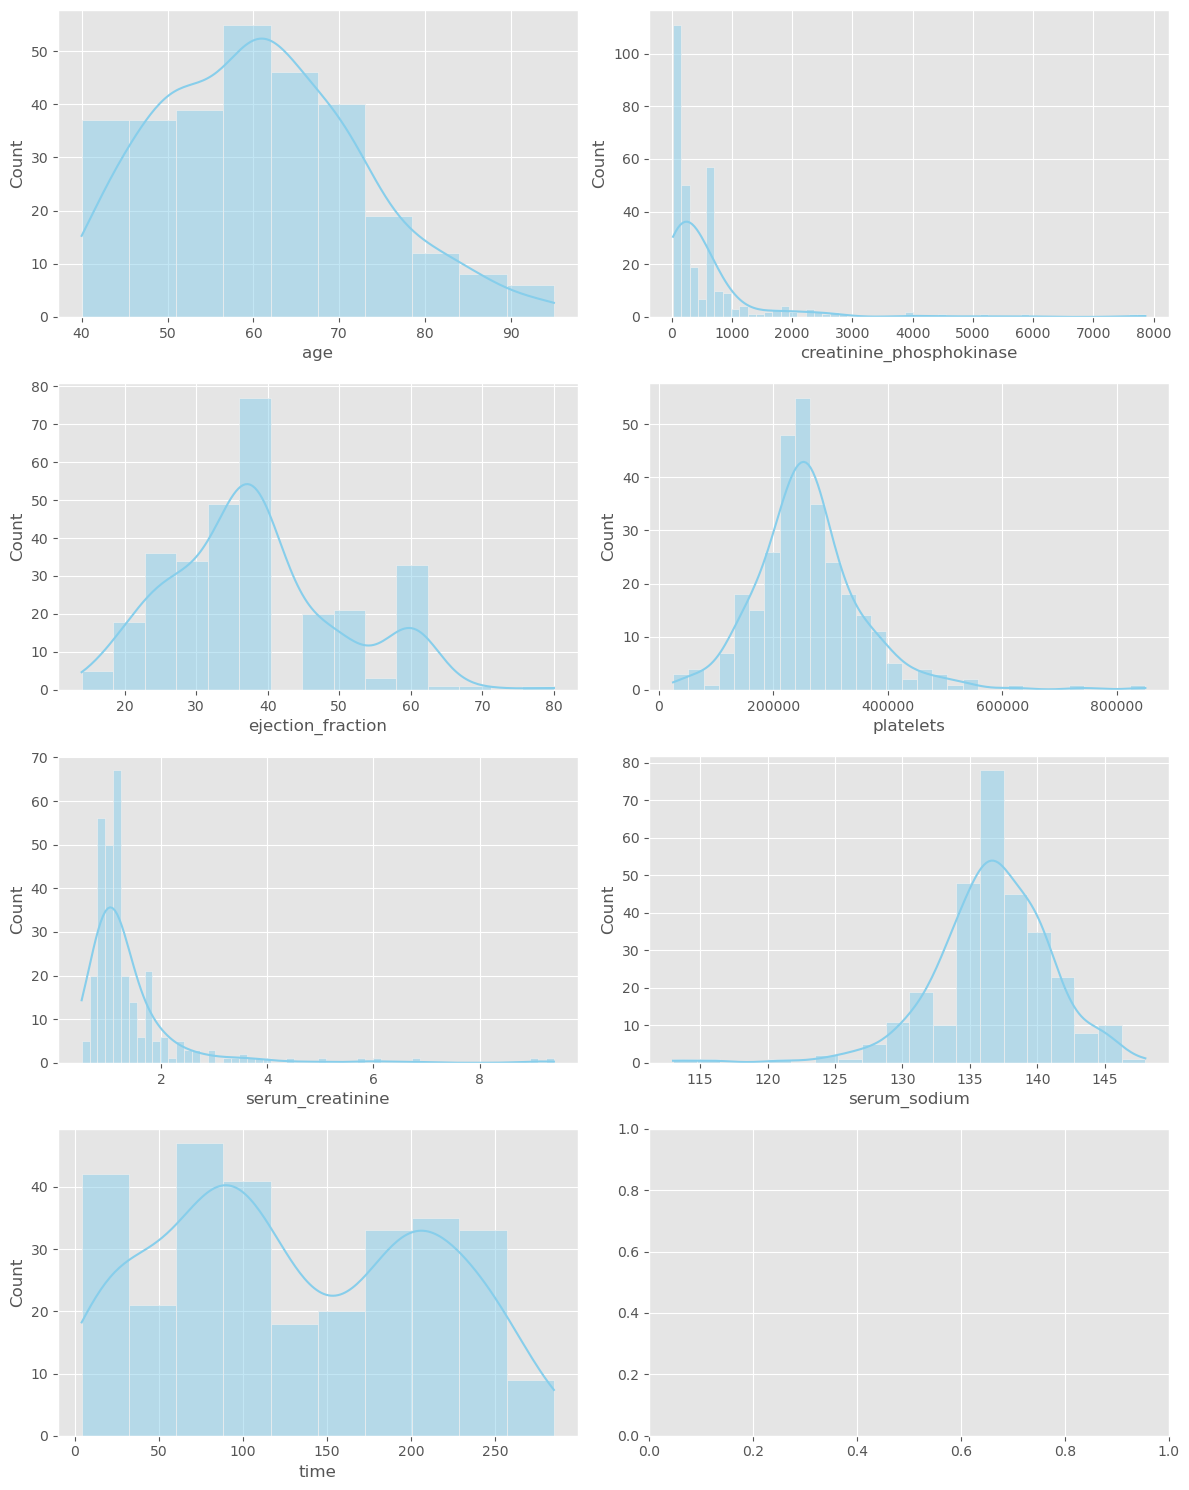

In [8]:
# Melihat distribusi dari kolom numerical
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, color='skyblue', ax=ax[i//2, i%2])

plt.tight_layout()
plt.show()

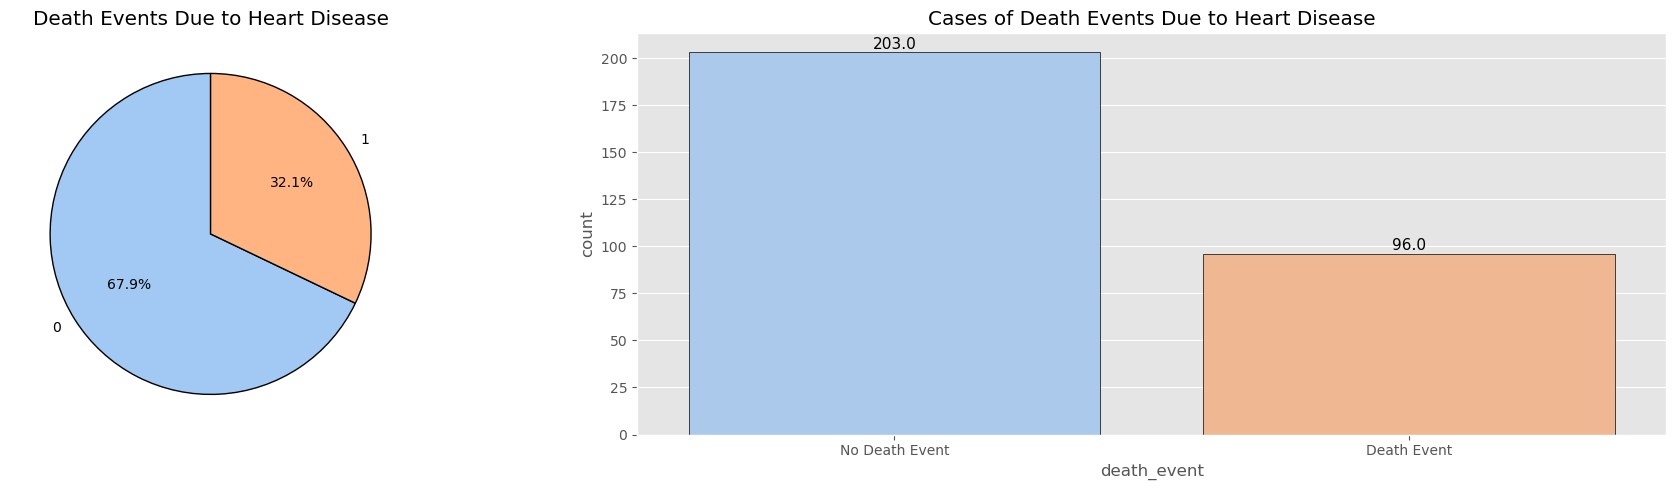

In [9]:
# persentase kategori pada kolom 'death_event'
death_counts = df['death_event'].value_counts(normalize=True) * 100

# visualisasi pie chart
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
colors = sns.color_palette('pastel')
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=90, colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Death Events Due to Heart Disease')

# visualisasi count plot
plt.subplot(1, 2, 2)
ax = sns.countplot(x='death_event', data=df, palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(),
            horizontalalignment='center', fontsize=11)
ax.set_xticklabels(['No Death Event', 'Death Event'])
plt.title('Cases of Death Events Due to Heart Disease')

plt.tight_layout()
plt.show()


Dari hasil tersebut dapat dilihat bahwa jumlah kasus tanpa kematian berjumlah 203 sedangkan jumlah kasus dengan kematian berjumlah 96, ini menunjukkan bahwa data yang tersedia tidak seimbang dikarenakan jumlah yang tidak seimbang.Prediksi akan cenderung condong kepada kasus Tidak Ada Kejadian Kematian. Visualisasi juga akan menampilkan kecondongan ini, sehingga sulit untuk mendapatkan wawasan yang jelas.

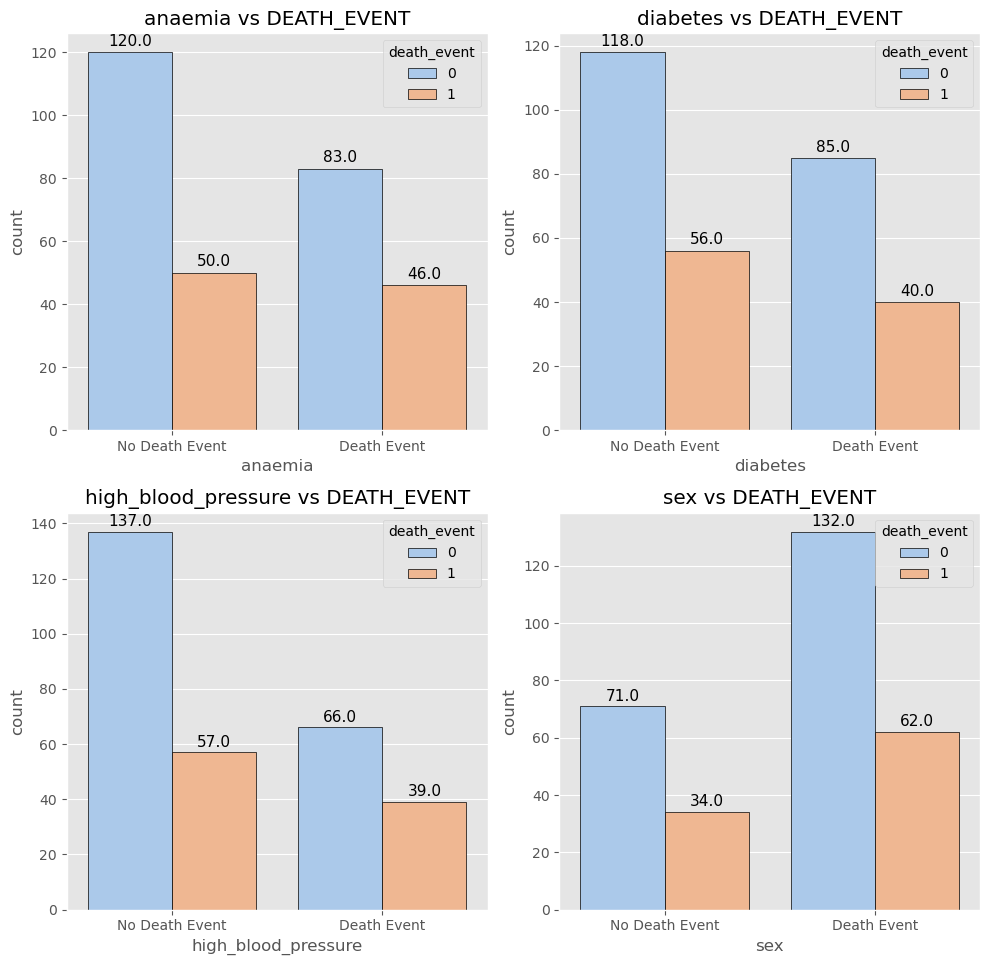

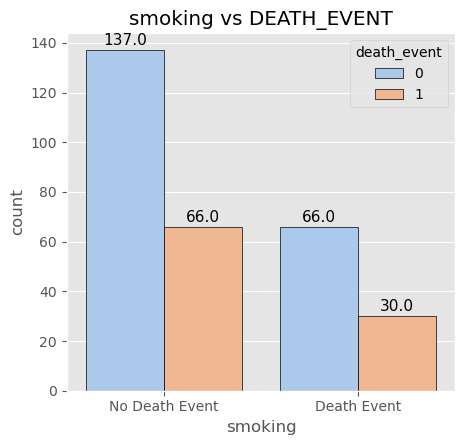

In [10]:
#Melihat perbandingan antara categorical features dengan kolom death_event
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9.75))
for i in range(len(cat_cols) - 2):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(x=cat_cols[i], hue="death_event", data=df, palette=colors, edgecolor='black', ax=ax)
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(),
                horizontalalignment='center', fontsize=11)
    ax.set_xticklabels(['No Death Event', 'Death Event'])
    title = cat_cols[i] + ' vs DEATH_EVENT'
    ax.set_title(title)

plt.tight_layout()


plt.figure(figsize=(4.75, 4.55))
last_ax = sns.countplot(x=cat_cols[-2], hue="death_event", data=df, palette=colors, edgecolor='black')
for rect in last_ax.patches:
    last_ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(),
                 horizontalalignment='center', fontsize=11)
last_ax.set_xticklabels(['No Death Event', 'Death Event'])
last_title = cat_cols[-2] + ' vs DEATH_EVENT'
last_ax.set_title(last_title)

plt.tight_layout()
plt.show()


Hampir semua grafik memiliki pola yang mirip. Dari grafik dapat terlihat pasien dengan kasus negatif anemia, diabetes, tekanan darah tinggi, dan kebiasaan merokok lebih cenderung mengalami kejadian kematian dibandingkan dengan kasus positif kondisi medis tersebut. Terdapat lebih banyak kasus pada populasi pria yang menghadapi kejadian kematian akibat gagal jantung dibandingkan populasi wanita.

In [11]:
#Melihat perbandingan data dari categorical features dengan kasus death_event
anaemia = df[df['death_event'] == 1]['anaemia'].value_counts()
anaemia = [anaemia[0] / sum(anaemia) * 100, anaemia[1] / sum(anaemia) * 100]

diabetes = df[df['death_event'] == 1]['diabetes'].value_counts()
diabetes = [diabetes[0] / sum(diabetes) * 100,diabetes[1] / sum(diabetes) * 100]

hbp = df[df['death_event'] == 1]['high_blood_pressure'].value_counts()
hbp = [hbp[0] / sum(hbp) * 100,hbp[1] / sum(hbp) * 100]

sex = df[df['death_event'] == 1]['sex'].value_counts()
sex = [sex[0] / sum(sex) * 100,sex[1] / sum(sex) * 100]

smoke = df[df['death_event'] == 1]['smoking'].value_counts()
smoke = [smoke[0] / sum(smoke) * 100,smoke[1] / sum(smoke) * 100]

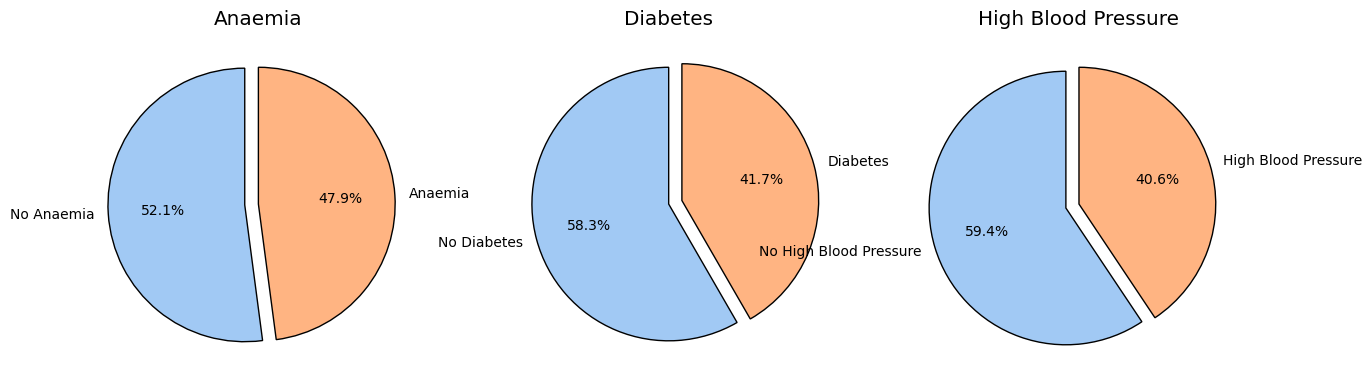

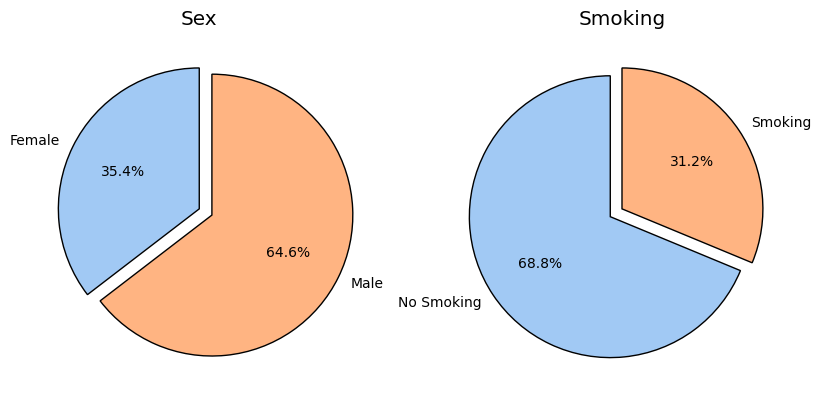

In [12]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (15,15))

plt.subplot(1,3,1)
plt.pie(anaemia,labels = ['No Anaemia','Anaemia'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Anaemia');

plt.subplot(1,3,2)
plt.pie(diabetes,labels = ['No Diabetes', 'Diabetes'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Diabetes');

plt.subplot(1,3,3)
plt.pie(hbp,labels = ['No High Blood Pressure','High Blood Pressure'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('High Blood Pressure');

ax,fig = plt.subplots(nrows = 1,ncols = 2,figsize = (10,10))
plt.subplot(1,2,1)
plt.pie(sex,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Sex');

plt.subplot(1,2,2)
plt.pie(smoke,labels = ['No Smoking','Smoking'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Smoking');

Dari visualisasi ini dapat dilihat bahwa kejadian kematian lebih banyak terjadi akibat kasus negatif anemia, diabetes, tekanan darah tinggi, dan kebiasaan merokok daripada kasus positifnya.
Dari total kasus gagal jantung yang mengakibatkan kejadian kematian, laki-laki lebih rentan daripada perempuan.

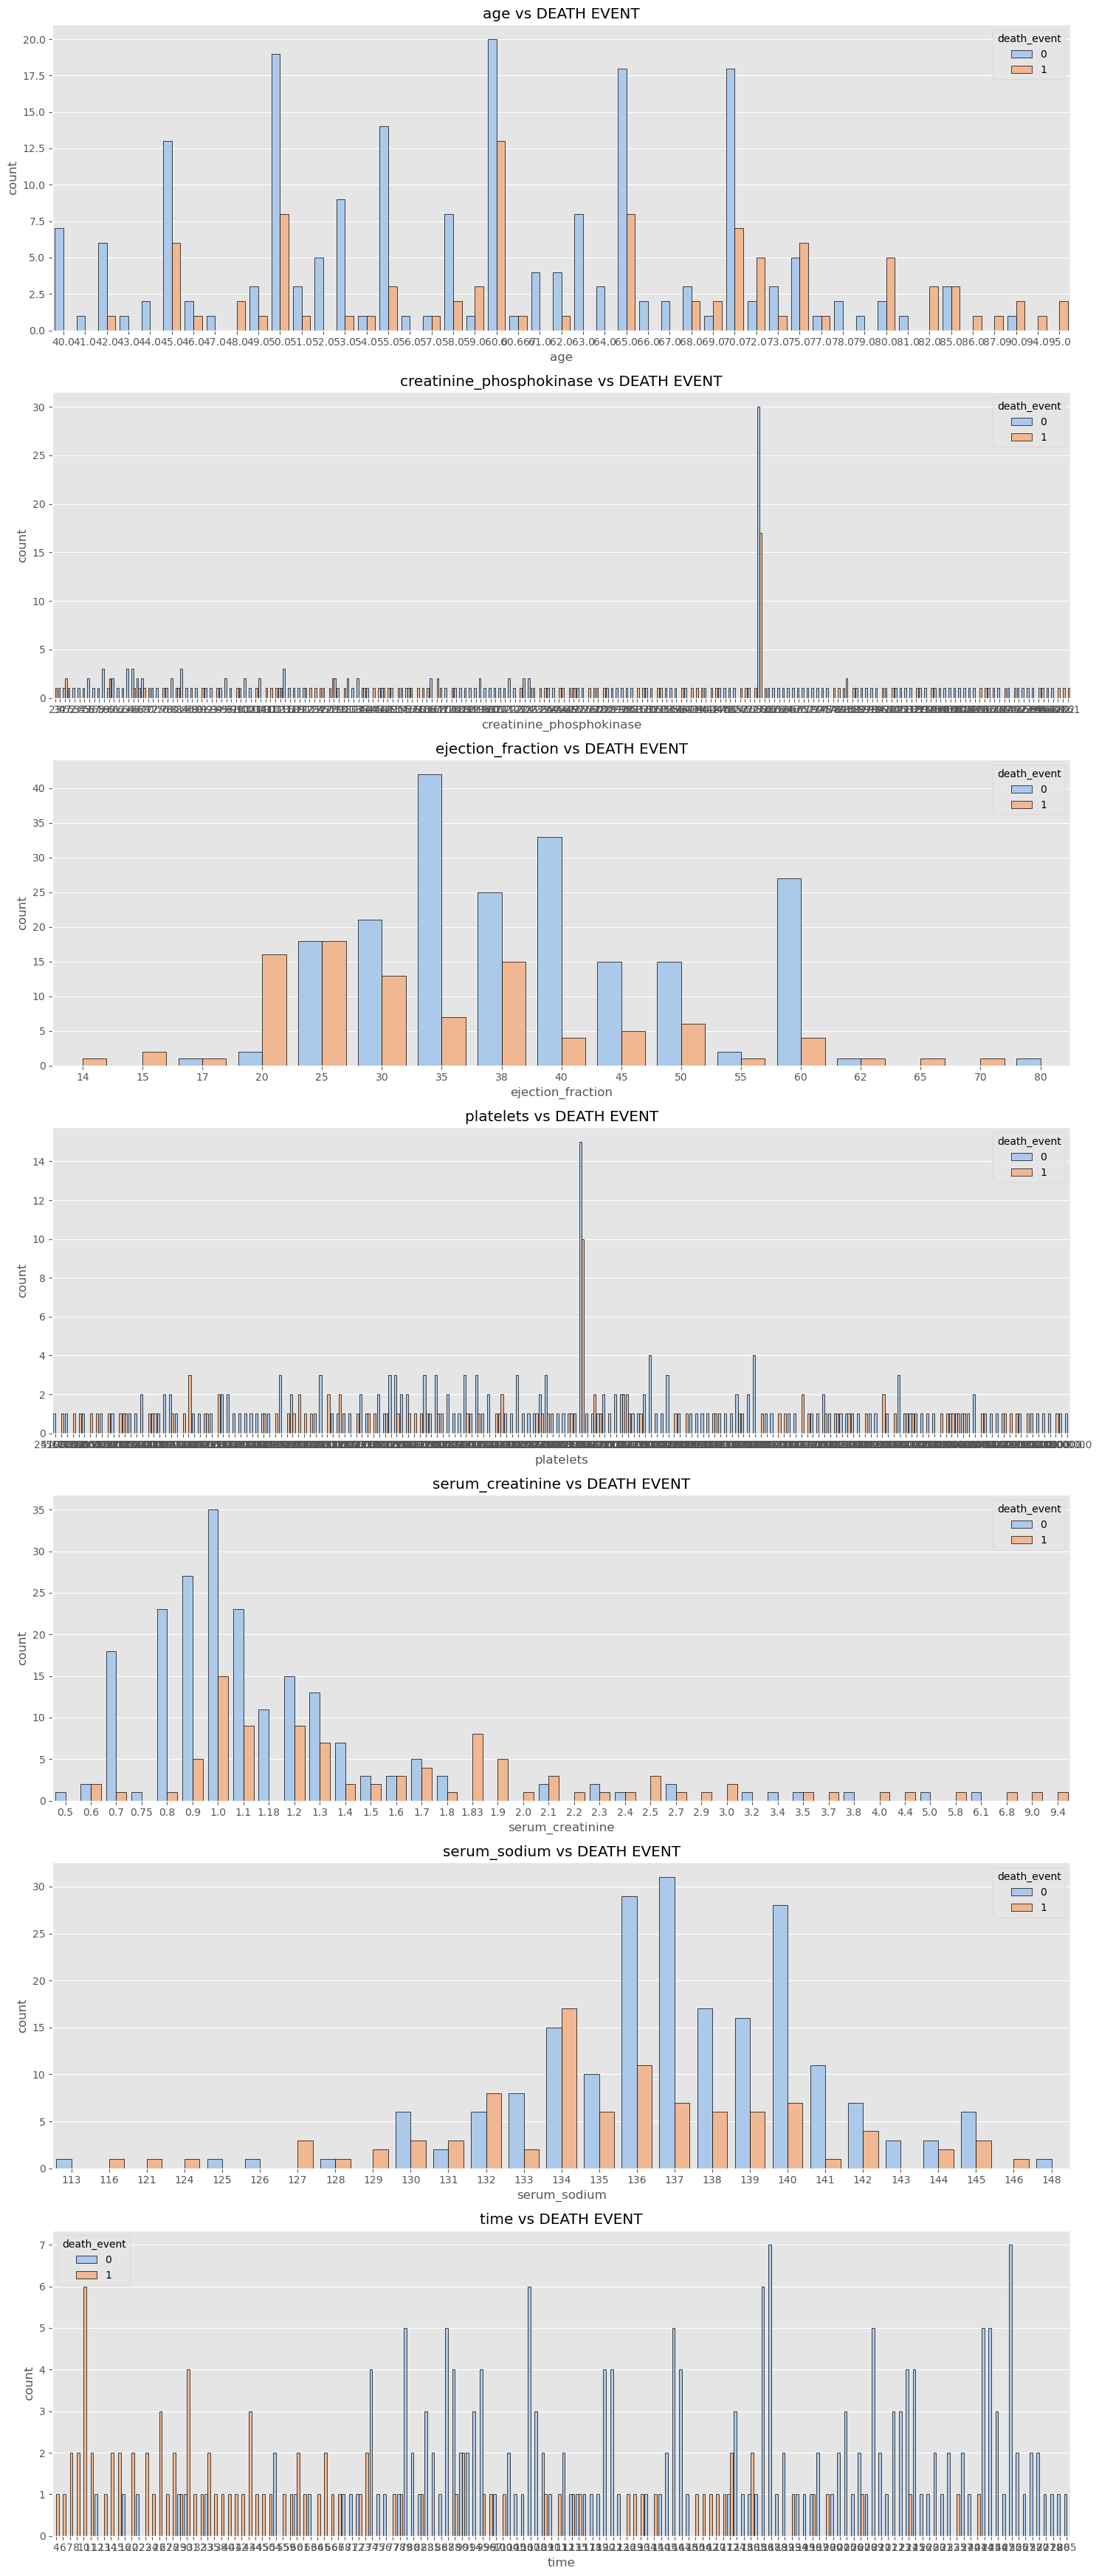

In [13]:
#Melihat perbandingan numerical features dengan death_event
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 35), squeeze=False)
for i in range(len(num_cols)):
    ax = axes[i, 0]
    sns.countplot(x=num_cols[i], data=df, hue="death_event", palette=colors, edgecolor='black', ax=ax)
    title = num_cols[i] + ' vs DEATH EVENT'
    ax.set_title(title)

plt.tight_layout()
plt.show()


Kasus kejadian kematian dimulai dari usia 45 tahun. Beberapa puncak tertentu dari kasus tinggi kejadian kematian dapat diamati pada usia 45, 50, 60, 65, 70, 75, dan 80 tahun.
Kasus tinggi kejadian kematian dapat diamati untuk nilai ejaksi fraksi antara 20 - 60.
Nilai serum kreatinin dari 0,6 hingga 3,0 memiliki probabilitas yang lebih tinggi untuk menyebabkan kejadian kematian.
Nilai serum sodium 127 - 145 mengindikasikan terjadinya kejadian kematian akibat gagal jantung.

Untuk creatinine phosphokinase, nilai antara 0 hingga 500 dan jumlah platelets antara 2x10^5 hingga 3x10^5 mendeteksi lebih banyak kasus kegagalan jantung. Demikian pula, kadar serum creatinine antara 1 hingga 2 dan nilai fitur waktu dari 0 hingga 100 menyoroti lebih banyak kasus kegagalan jantung.

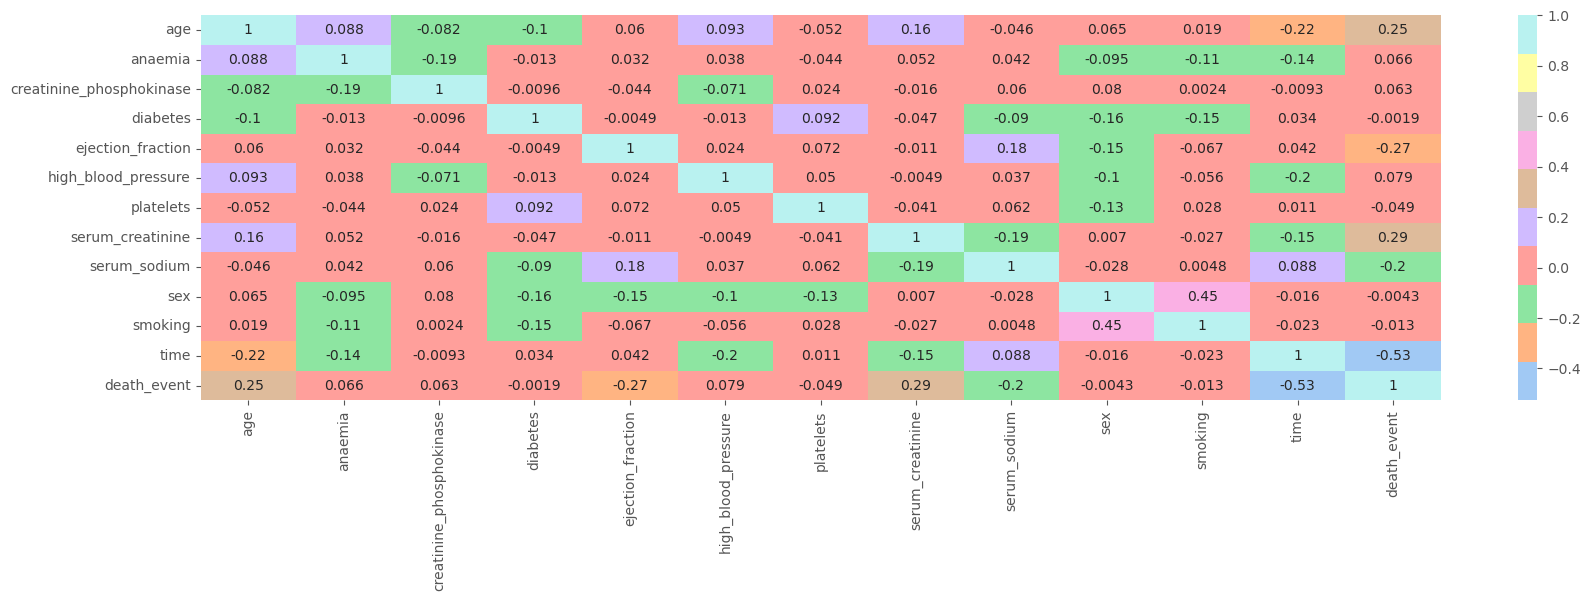

In [14]:
#Matrix Korelasi
plt.figure(figsize = (20,5))
sns.heatmap(df.corr(),cmap = colors,annot = True);

In [15]:
df.corr()['death_event'].sort_values(ascending=False)

death_event                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: death_event, dtype: float64

Fitur seperti high_blood_pressure, anaemia, creatinine_phosphokinase, diabetes, sex, smoking, and platelets  tidak menunjukkan adanya korelasi dengan kejadian kematian.

# Data Preprocessing

In [16]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
et=ExtraTreesClassifier()
et.fit(X,y)

ExtraTreesClassifier()

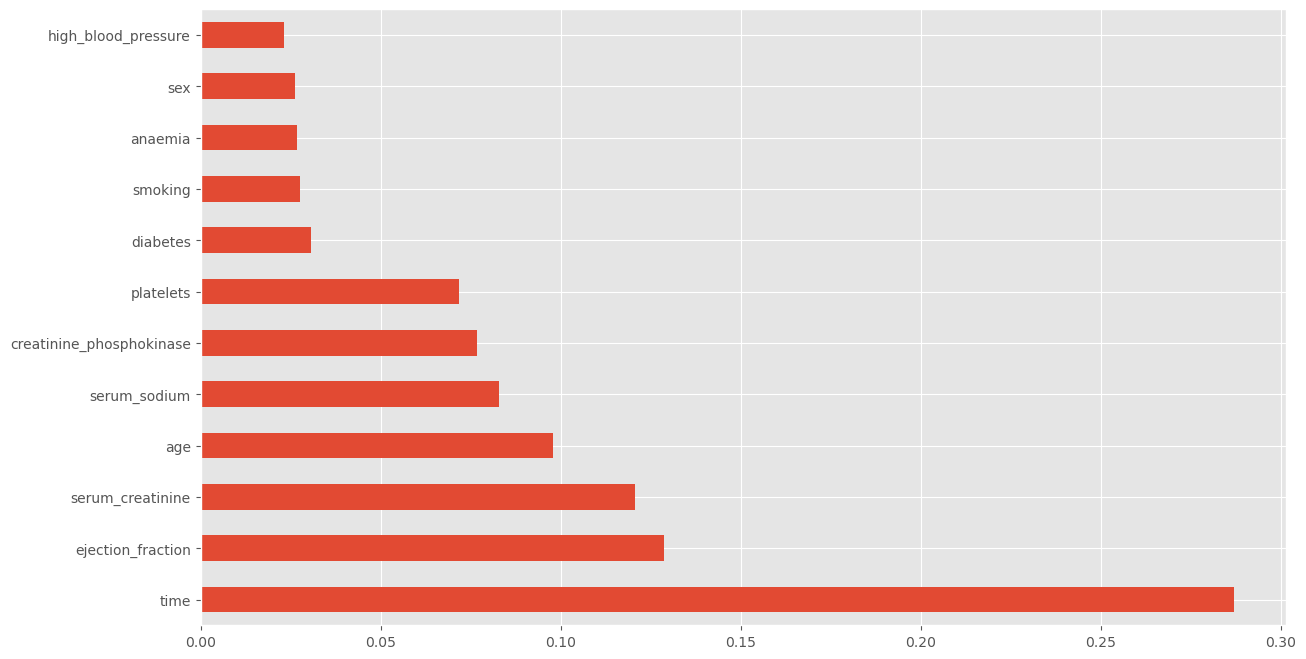

In [18]:
et.feature_importances_


plt.figure(figsize=(14,8))
feat_importances=pd.Series(et.feature_importances_,index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

In [19]:
#Memilih 4 feature dengan nilai tertinggi
X = df[['time', 'ejection_fraction', 'serum_creatinine','age']]
y = df['death_event']

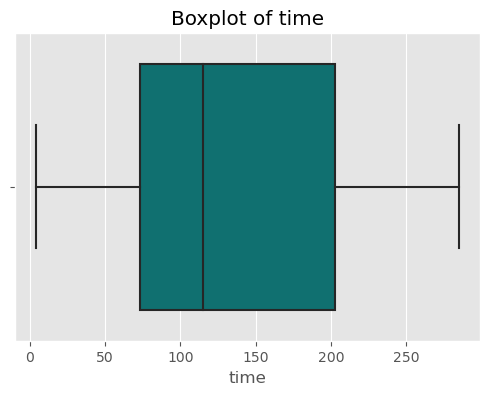

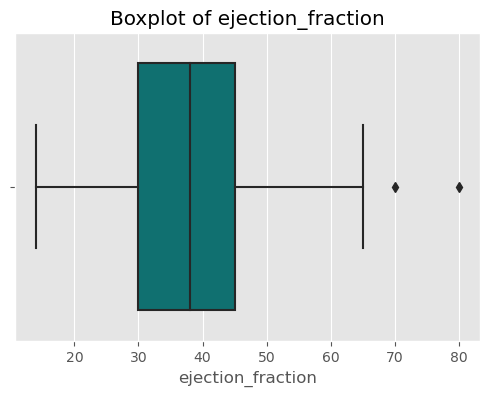

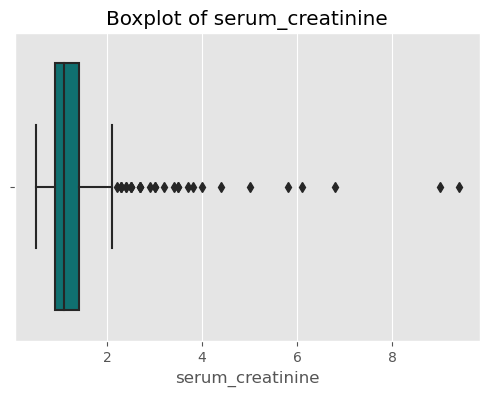

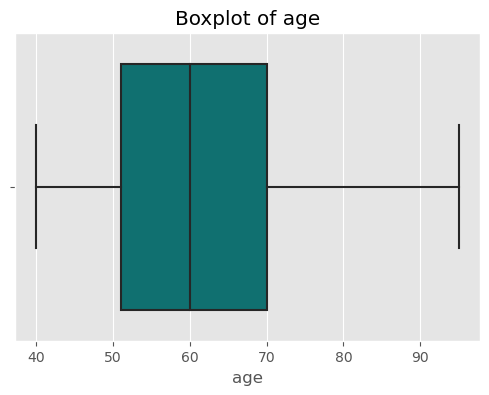

In [20]:
#Melihat apakah terdapat outlier
selected_columns = ['time', 'ejection_fraction', 'serum_creatinine', 'age']

# Looping untuk membuat boxplot untuk setiap kolom
for column in selected_columns:
    plt.figure(figsize=(6, 4))  # Ukuran gambar
    sns.boxplot(x=df[column], color='teal')
    plt.title(f'Boxplot of {column}')
    plt.show()

Menghapus outliers tanpa alasan yang jelas tidak selalu dapat meningkatkan akurasi. Sebelum menghapus outliers kita perlu memahami apakah data tersebut merupakan outliers atau bukan. 

In [21]:
# Menghapus outlier dati kolom ejection_fraction
df[df['ejection_fraction']>=70]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
64,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
217,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,196,1


In [22]:
#Membuat dataframe baru dengan tanpa outliers
df1=df[df['ejection_fraction']<70]

# Model Definition dan Training

In [23]:
#features yang digunakan untuk membentuk model
X = df1[['time', 'ejection_fraction', 'serum_creatinine','age']]
y = df1['death_event']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)


scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Model Prediction dan Evaluation

In [25]:
# Model logistic regression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)


logpred=classifier.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test,logpred)
print(classification_report(y_test,logpred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           1       0.81      0.76      0.79        17

    accuracy                           0.88        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.88      0.88      0.88        60



In [27]:
# Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi pada data test
predictions = rf_model.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))


Accuracy: 0.9
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.82      0.82      0.82        17

    accuracy                           0.90        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.90      0.90      0.90        60



In [28]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Model lainnya
log_reg = LogisticRegression(max_iter=1000, random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)

# Ensemble menggunakan teknik Voting Classifier
ensemble_model = VotingClassifier(estimators=[('lr', log_reg), ('dt', dec_tree), ('rf', rf_model)], voting='hard')
ensemble_model.fit(X_train, y_train)

# Prediksi dengan model ensemble
ensemble_pred = ensemble_model.predict(X_test)

# Evaluasi model ensemble
print("Ensemble Model Accuracy:", accuracy_score(y_test, ensemble_pred))
print("Ensemble Model Classification Report:")
print(classification_report(y_test, ensemble_pred))


Ensemble Model Accuracy: 0.9166666666666666
Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.83      0.88      0.86        17

    accuracy                           0.92        60
   macro avg       0.89      0.91      0.90        60
weighted avg       0.92      0.92      0.92        60



Dari model yang telah dihasilkan dapat dilihat model terbaik didapatkan dari ensemble model yang menggabungkan beberapa model. 

In [29]:
data = {
    "prediction": ensemble_pred,
    "actual": y_test,
    "conclusion": [i == j for i, j in zip(y_test, ensemble_pred)]
}

# Buat DataFrame dari data
result_df = pd.DataFrame(data).head(10)
print(result_df)

     prediction  actual  conclusion
112           1       0       False
151           0       0        True
12            1       1        True
218           0       0        True
140           0       1       False
75            1       1        True
209           0       0        True
172           0       0        True
188           0       0        True
215           0       0        True


# Final Model

In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump

# Model lainnya
log_reg = LogisticRegression(max_iter=1000, random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)

# Ensemble menggunakan teknik Voting Classifier
ensemble_model = VotingClassifier(estimators=[('lr', log_reg), ('dt', dec_tree), ('rf', rf_model)], voting='hard')
ensemble_model.fit(X_train, y_train)

# Simpan model ensemble dalam format JSON
dump(ensemble_model, 'ensemble_model.json')
print("Model ensemble disimpan sebagai ensemble_model.json")


Model ensemble disimpan sebagai ensemble_model.json


# Kesimpulan

Kesimpulan dari proses yang telah dilakukan adalah, model terbaik didapatkan dari ensemble model dengan menggabungkan beberapa algortima yaitu logistic regression, decision tree, serta random forest. Dengan akurasi model sebesar 0.9166666666666666 yang menunjukkan sekitar 91.67% prediksi yang benar pada dataset uji. Presisi untuk kelas 0 (kondisi negatif) adalah 95% dan untuk kelas 1 (kondisi positif) adalah 83%. Ini mengindikasikan seberapa tepat model dalam mengidentifikasi setiap kelas. Recall untuk kelas 0 adalah 93%, sementara untuk kelas 1 adalah 88%. Recall mengukur seberapa baik model dapat menemukan kembali instance positif dalam dataset.F1-score  untuk kelas 0 adalah 0.94 dan untuk kelas 1 adalah 0.86. 

model ensemble memiliki kinerja yang baik dalam mengklasifikasikan kedua kelas, walaupun ada sedikit perbedaan dalam presisi dan recall antara kelas 0 dan kelas 1. Dengan akurasi yang tinggi, model ini mampu memberikan prediksi yang baik untuk kedua kelas pada dataset yang digunakan.